# Training a conventional Singleoutput GP with GPytorch

In [1]:
import math

import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Set up some training data

$$
\begin{align}
y &= \sin(2\pi x) + \epsilon \\
  \epsilon &\sim \mathcal{N}(0, 0.04)
\end{align}
$$
With 100 training examples (regularly spaced points in [0,1]) and 51 test examples

In [2]:
# training data, 100 points in [0,1]
train_x = torch.linspace(0, 1, 100)
train_y = torch.sin(2 * math.pi * train_x) + torch.randn(train_x.size()) * math.sqrt(0.04)

## Setting up the model
A **GP Model** `gpytorch.models.ExactGP` with:
- **Likelihood** `gpytorch.likelihoods.GaussianLikelihood`
- **Zero Mean** `gpytorch.means.ZeroMean` for simplicity
- **RBF Kernel** `gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())`


In [3]:
class ConventionalGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ConventionalGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        r"""
        Takes in some n x d data :math:`\mathbf{x}` and returns a :obj:`~gpytorch.distributions.MultivariateNormal` with prior mean and covariance matrix of the GP
        :param x:
        :return:
        """
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# init likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ConventionalGPModel(train_x, train_y, likelihood)

## Training the model

- Using Type-II MLE with custom training loop, as in standard PyTorch
- All trainable parameters shoud be of type `torch.nn.Parameter`, since GP models extend `torch.nn.Module`

Standard PyTorch training loop:
1. Zero all parameter gradients
2. Call the model and compute loss
3. Call backward on loss to fill in gradients
4. Take a step on the optimizer

In [4]:
# set model in training mode
model.train()
likelihood.train()

# use adam optimizer, including the GaussianLikelihood parameters
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# "Loss" for GPs - marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(5000):
    # zero gradients from previous iteration
    optimizer.zero_grad()

    # output from model
    output = model(train_x)

    # calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    if i == 0 or (i + 1) % 10 == 0:
        print(
            f'Iter {i + 1:02d}/50 - '
            f'Loss: {loss.item():.3f}   '
            f'lengthscale: {model.covar_module.base_kernel.lengthscale.item():.3f}   '
            f'noise: {model.likelihood.noise.item():.3f}'
        )

    # step on optimizer
    optimizer.step()

Iter 01/50 - Loss: 0.943   lengthscale: 0.693   noise: 0.693
Iter 10/50 - Loss: 0.547   lengthscale: 0.342   noise: 0.339
Iter 20/50 - Loss: 0.198   lengthscale: 0.211   noise: 0.134
Iter 30/50 - Loss: -0.045   lengthscale: 0.263   noise: 0.053
Iter 40/50 - Loss: -0.050   lengthscale: 0.303   noise: 0.030
Iter 50/50 - Loss: -0.059   lengthscale: 0.263   noise: 0.033
Iter 60/50 - Loss: -0.067   lengthscale: 0.283   noise: 0.041
Iter 70/50 - Loss: -0.067   lengthscale: 0.272   noise: 0.042
Iter 80/50 - Loss: -0.068   lengthscale: 0.276   noise: 0.039
Iter 90/50 - Loss: -0.068   lengthscale: 0.276   noise: 0.038
Iter 100/50 - Loss: -0.068   lengthscale: 0.276   noise: 0.039
Iter 110/50 - Loss: -0.068   lengthscale: 0.277   noise: 0.039
Iter 120/50 - Loss: -0.068   lengthscale: 0.277   noise: 0.039
Iter 130/50 - Loss: -0.068   lengthscale: 0.277   noise: 0.039
Iter 140/50 - Loss: -0.068   lengthscale: 0.277   noise: 0.039
Iter 150/50 - Loss: -0.068   lengthscale: 0.277   noise: 0.039
Iter 

## Make predictions with the model

- User defined model returns `MultivariateNormal` with prior mean and covariance from forward
- Trained model in eval mode returns `MultivariateNormal` with posterior mean and covariance

A test point (`test_x`) denoted as `X*` with true output `Y*` and training data `X, Y`:
- `model(test_x)` returns model posterior distribution `p(f* | X*, X, Y)`
    - posterior is distribution over the function we are trying to model and thus quantifies model unvertainty
- `likelihood(model(test_x))` gives us posterior predictive distribution `p(Y* | X*, X, Y)`
    - probability distribution over predicted output value

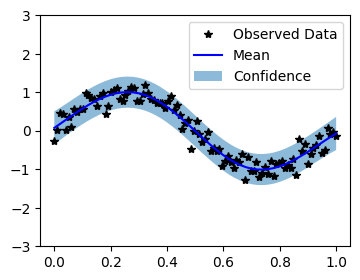

In [5]:
# set model to evaluation mode (predictive posterior)
model.eval()
likelihood.eval()

# test points are regularly spaced alon [0, 1]
# make predictions by feeding model through likelihood
with torch.no_grad():
    test_x = torch.linspace(0, 1, 51)
    observed_pred = likelihood(model(test_x))

# plot model fit
with torch.no_grad():
    # initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()

    # plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')

    # plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')

    # shade between lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])

    ax.legend(['Observed Data', 'Mean', 'Confidence'])

Getting predictive mean and variance and sampling functions from GP:

In [6]:
f_preds = model(test_x)
y_pred = likelihood(model(test_x))

print(f_preds.mean)
print(f_preds.variance)
print(f_preds.covariance_matrix.size())
print(f_preds.covariance_matrix)
print(f_preds.sample(sample_shape=torch.Size((1000,)))[0,:])

tensor([ 0.0755,  0.1769,  0.2792,  0.3809,  0.4804,  0.5759,  0.6657,  0.7481,
         0.8216,  0.8845,  0.9354,  0.9731,  0.9964,  1.0044,  0.9966,  0.9727,
         0.9325,  0.8763,  0.8049,  0.7191,  0.6202,  0.5098,  0.3898,  0.2623,
         0.1296, -0.0059, -0.1415, -0.2747, -0.4030, -0.5238, -0.6349, -0.7343,
        -0.8201, -0.8909, -0.9456, -0.9835, -1.0042, -1.0080, -0.9951, -0.9664,
        -0.9231, -0.8665, -0.7984, -0.7206, -0.6350, -0.5436, -0.4486, -0.3519,
        -0.2554, -0.1609, -0.0699], grad_fn=<ViewBackward0>)
tensor([0.0077, 0.0050, 0.0035, 0.0026, 0.0022, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0020, 0.0020, 0.0019, 0.0019, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018,
        0.0018, 0.0018, 0.0019, 0.0019, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0022, 0.0026, 0.0035, 0.0050, 0.0077],
  

C:\Users\pasca\Documents\Studienarbeit\PythonProject\venv\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
C:\Users\pasca\Documents\Studienarbeit\PythonProject\venv\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
